# 3.8.4 Bungee Dunk

---

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In [ ]:
#@title
# Import necessary libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
import pandas as pd
import numpy as np

Downloaded ModSimPy_Functions/modsim.py


In the previous notebook, we simulated a bungee jump with a model that took into account gravity, air resistance, and the spring force of the bungee cord, but we ignored the weight of the cord.

<br>

It is tempting to say that the weight of the cord doesn't matter because it falls along with the jumper.  But that intuition is incorrect, as explained by [Heck, Uylings, and Kędzierska](http://iopscience.iop.org/article/10.1088/0031-9120/45/1/007).  As the cord falls, it transfers energy to the jumper.   They derive a differential equation that relates the acceleration of the jumper to position and velocity:

$a = g + \frac{\mu v^2/2}{\mu(L+y) + 2L}$ 

where $a$ is the net acceleration of the jumper, $g$ is acceleration due to gravity, $v$ is the velocity of the jumper, $y$ is the position of the jumper relative to the starting point (usually negative), $L$ is the length of the cord, and $\mu$ is the mass ratio of the cord and jumper.

How does the behavior of the system change as we vary the mass of the cord? How does the acceleration change as the jumper falls? When the mass of the cord equals the mass of the jumper, what is the net effect on the lowest point in the jump?

If you don't believe this model is correct, [this video might convince you](https://www.youtube.com/watch?v=X-QFAB0gEtE).

Following the previous case study, we'll model the jump with the following assumptions:

1. Initially the bungee cord hangs from a crane with the attachment point 80 m above a cup of tea.

2. Until the cord is fully extended, it applies a force to the jumper as explained above.

3. After the cord is fully extended, it obeys [Hooke's Law](https://en.wikipedia.org/wiki/Hooke%27s_law); that is, it applies a force to the jumper proportional to the extension of the cord beyond its resting length.

4. The jumper is subject to drag force proportional to the square of their velocity, in the opposite of their direction of motion.

First I'll create a `params` object to contain the quantities we'll need:

1. Let's assume that the jumper's mass is 75 kg and the cord's mass is also 75 kg, so `mu=1`.

2. The jumpers's frontal area is 1 square meter, and terminal velocity is 60 m/s.  I'll use these values to back out the coefficient of drag.

3. The length of the bungee cord is `L = 25 m`.

4. The spring constant of the cord is `k = 40 N / m` when the cord is stretched, and 0 when it's compressed.

I adopt the coordinate system and most of the variable names from [Heck, Uylings, and Kędzierska](http://iopscience.iop.org/article/10.1088/0031-9120/45/1/007).

In [ ]:
params = dict(y_attach = 80,   # m,
                 v_init = 0,     # m / s,
                 g = 9.8,        # m/s**2,
                 m_person = 75,   # kg,
                 m_cord = 75,    # kg
                 area = 1,       # m**2,
                 rho = 1.2,      # kg/m**3,
                 v_term = 60,    # m / s,
                 L = 25,         # m,
                 k = 40)         # N / m

Now here's a version of `make_system` that takes a `params` object as a parameter.

`make_system` uses the given value of `v_term` to compute the drag coefficient `C_d`.

It also computes `mu` and the initial `state` object.

In [ ]:
def make_system(params):
    """Makes a System object for the given params.
    
    params: Params object
    
    returns: System object
    """
    y_attach, v_init, g, m_person, m_cord, area, rho, v_term, L, k = params.values()
    
    # back out the coefficient of drag
    C_d = 2 * m_person * g / (rho * area * v_term**2)
    
    mu = m_cord / m_person
    init = pd.Series(dict(y=y_attach, v=v_init))
    t_end = 8

    return dict(y_attach=y_attach, v_init=v_init, g=g,
                m_person=m_person, m_cord=m_cord, area=area, rho=rho,
                v_term=v_term, L=L, k=k,mu=mu,
                C_d=C_d, init=init, t_end=t_end)

Let's make a `system`

In [ ]:
system1 = make_system(params)

`drag_force` computes drag as a function of velocity:

In [ ]:
def drag_force(v, system):
    """Computes drag force in the opposite direction of `v`.
    
    v: velocity
    
    returns: drag force in N
    """
    rho, C_d, area = system['rho'], system['C_d'], system['area']

    f_drag = -np.sign(v) * rho * v**2 * C_d * area / 2
    return f_drag

Here's drag force at 20 m/s.

In [ ]:
drag_force(20, system1)

-81.66666666666667

The following function computes the acceleration of the jumper due to tension in the cord.

$a_{cord} = \frac{\mu v^2/2}{\mu(L+y) + 2L}$ 

In [ ]:
def cord_acc(y, v, system):
    """Computes the force of the bungee cord on the jumper. If
    the cord is not extended, this force is due to the weight 
    of the cord.  If it is extended, the force is due to Hooke's
    Law:
    
    y: height of the jumper
    v: velocity of the jumpter
    
    returns: acceleration in m/s
    
    Note: the y in the a_cord equation is the height relative to
    the attachment point: that is represented here as rel_y
    """
    
    L, mu, y_attach= system['L'], system['mu'], system['y_attach']
    m_person, k = system['m_person'], system['k']
    
    height_ext = y_attach - L
    rel_y = y - y_attach
    
    if np.abs(rel_y) < L:
        a_cord = -(mu* v**2 *0.5) / (2*L + (mu* (L+rel_y)))
    else:
        extension = height_ext - y
        a_cord = (k * extension)/m_person
    return a_cord

Here's acceleration due to tension in the cord if we're going 20 m/s after falling 20 m.

In [ ]:
y = 60
v = -20
cord_acc(y, v, system1)

-3.6363636363636362

Now here's the slope function:

In [ ]:
def slope_func(t, state, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    y, v = state
    m_person, g = system['m_person'], system['g']
    
    a_drag = drag_force(v, system) / m_person
    a_cord = cord_acc(y, v, system)
    dvdt = -g + a_cord + a_drag
    
    return v, dvdt

As always, let's test the slope function with the initial params.

In [ ]:
slope_func(0, system1['init'], system1)

(0, -9.8)

And then run the simulation.

In [ ]:
results1, details1 = run_solve_ivp(system1, slope_func)
details1.message

'The solver successfully reached the end of the integration interval.'

Here's the plot of position as a function of time.

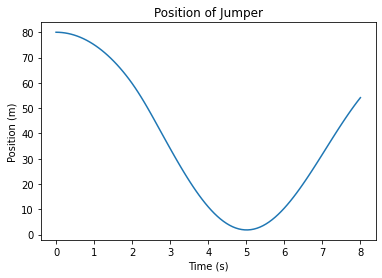

In [ ]:
def plot_position(results,**options):
    results.y.plot(xlabel='Time (s)',
                   ylabel='Position (m)',
                  title='Position of Jumper',**options)
    
plot_position(results1)

We can use `min` to find the lowest point:

In [ ]:
min(results1.y)

1.8220746537446844

To see how big the effect of the cord is, I'll collect the previous code in a function.

Now we can run both phases and get the results in a single `DataFrame`.

In [ ]:
params_no_cord = params.copy()
params_no_cord.update(dict(m_cord=1))
system_no_cord = make_system(params_no_cord)
results_no_cord, details1 = run_solve_ivp(system_no_cord, slope_func)


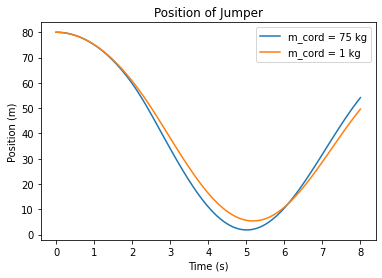

In [ ]:
plot_position(results1, label='m_cord = 75 kg',legend=True)
plot_position(results_no_cord, label='m_cord = 1 kg',legend=True)

In [ ]:
min(results_no_cord.y)

5.362796330631191

In [ ]:
diff = min(results1.y) - min(results_no_cord.y)
diff

-3.540721676886507

The difference is considerable: certainly large enough to be the difference between a successful bungee dunk and a bad day.

Let's compare the size of the accelerations throughout the simulation.  We'll use the data from `results1` to allow us to go back in and recalculate the accelerations:

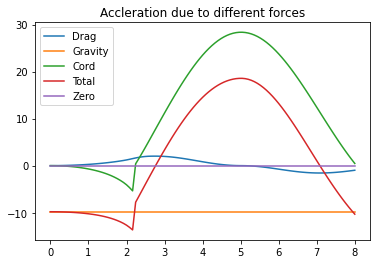

In [ ]:
accel = pd.DataFrame([],index=results1.index,
                     columns=["Drag","Gravity","Cord","Total","Zero"])
for t1 in results1.index:
    y, v = results1.loc[t1]
    drag = drag_force(v,system1)/system1['m_person']
    grav = -9.8
    cord = cord_acc(y,v,system1)
    total = drag + grav + cord
    accel.loc[t1]= [drag,grav,cord,total,0.0]
accel.plot(title='Accleration due to different forces');

Notice that the plot of the acceleration caused by the mass of the cord (from 0 s to about 2.2 s) looks very similar to the acceleration of the block with a chain shown in the Heck paper cited above (see p. 66).  This provides a nice experimental validation of our simulation!